# Generating images using Stable Diffusion

This notebook shows how to generate images using the [Stability AI's](https://stability.ai/) Stable Diffusion model. This code uses Keras' implementation.

The code in this notebook is inspired by the following work:

* [High-performance image generation using Stable Diffusion in KerasCV](https://keras.io/guides/keras_cv/generate_images_with_stable_diffusion/) by François Chollet, Luke Wood, and Divam Gupta.
* [A walk through latent space with Stable Diffusion](https://keras.io/examples/generative/random_walks_with_stable_diffusion/) by Ian Stenbit, François Chollet, and Luke Wood.


## Running this notebok in Google Colab?
If you are running this notebook in Google Colab, start by installing the following dependencies:

In [3]:
!pip install tensorflow keras_cv --upgrade --quiet
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

## Generating images

In [1]:
import time
import math
import keras_cv
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image 
from tensorflow import keras
from IPython.display import Image as IImage

We need to make sure we have access to a GPU.

In [2]:
print("TensorFlow has access to the following devices:")
for device in tf.config.list_physical_devices():
    print(f"• {device}")


TensorFlow has access to the following devices:
• PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
• PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


A few auxiliary functions that we will use later to plot and save the images that we generate.

In [3]:
def plot(images):
    """
    Plots every generated image on the screen.
    """
    plt.figure(figsize=(20, 20))

    for index, image in enumerate(images):
        ax = plt.subplot(1, len(images), index + 1)
        plt.imshow(image)
        plt.axis("off")

def save(image, filename):
    """
    Saves the supplied image to the specified filename.
    """
    im = Image.fromarray(image)
    im.save(filename)

def export_as_gif(images, filename, frames_per_second=10):
    """
    Exports the supplied images as a GIF animation.
    """
    images += images[2:-1][::-1]
    images[0].save(
        filename,
        save_all=True,
        append_images=images[1:],
        duration=1000 // frames_per_second,
        loop=0,
    )

We can now create the Stable Diffusion model. When creating the model, we can specify the dimensions of the image we want to generate. Keep in mind that if you try to generate images larger than 512x512, you will see a decrease in quality.

In [4]:
model = keras_cv.models.StableDiffusion(
    img_width=512, 
    img_height=512
)

Metal device set to: Apple M1 Ultra


2022-10-04 20:52:50.312288: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-04 20:52:50.312539: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


Generating an image is as simple as calling the `text_to_image()` function passing a prompt.

2022-10-01 12:15:01.238194: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-01 12:15:01.239442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-01 12:15:03.946080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 29s 859ms/step


2022-10-01 12:15:31.838702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


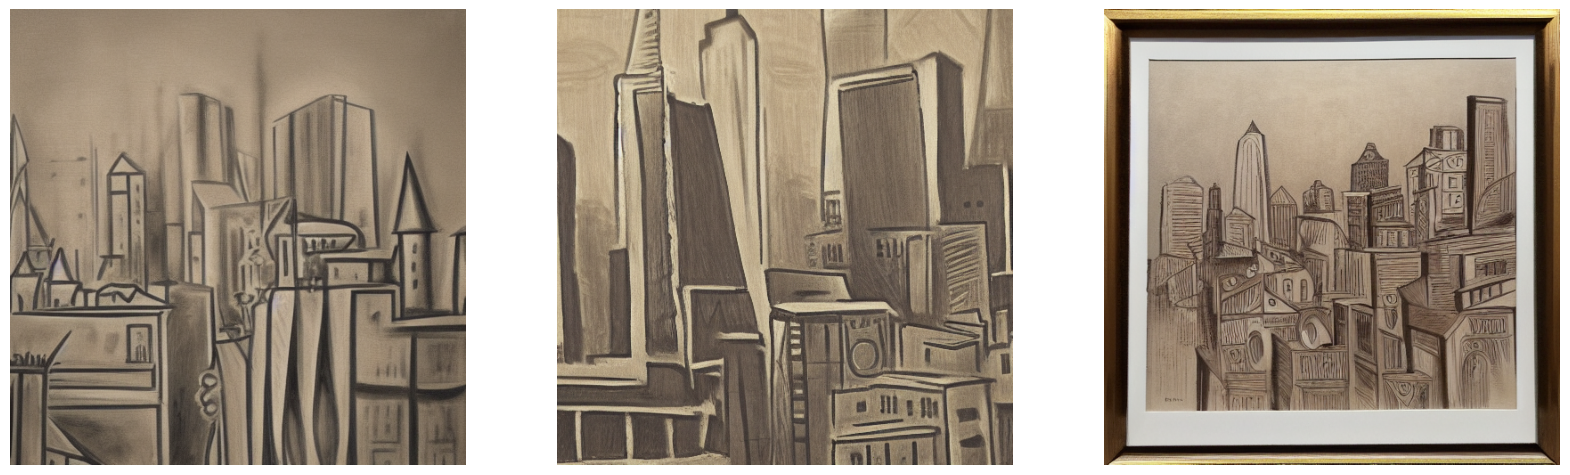

In [5]:
images = model.text_to_image(
    "sepia painting using picasso style, high definition"
    "futuristic city with a lot of buildings",
    batch_size=3
)

plot(images)

25/25 [==============================] - 22s 845ms/step


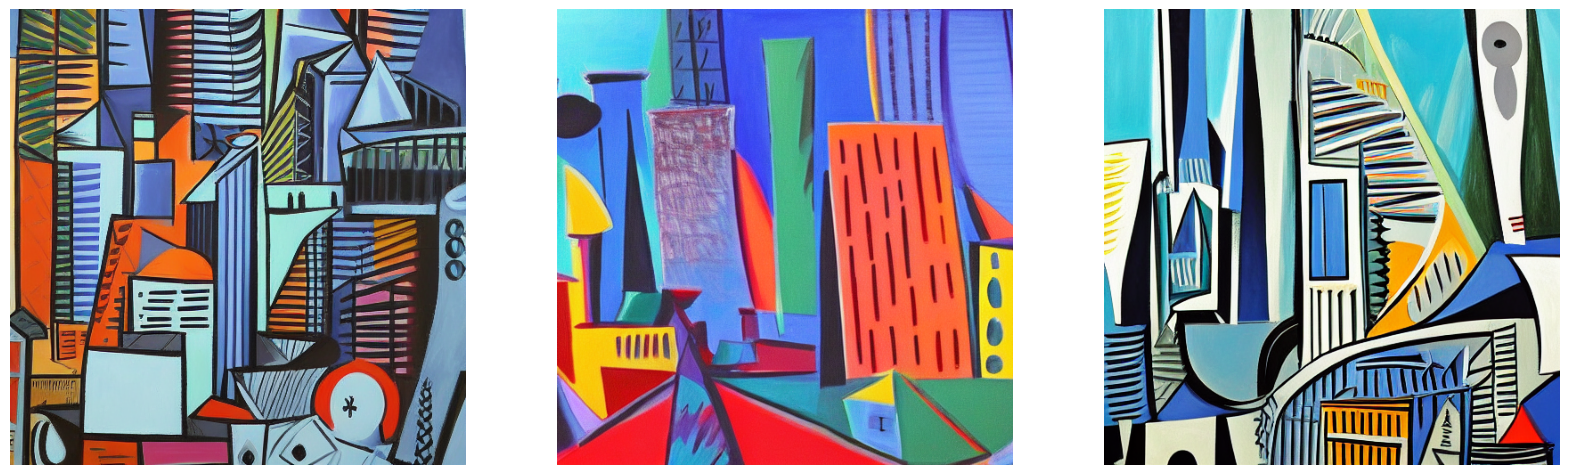

In [28]:
images = model.text_to_image(
    "painting using picasso style"
    "futuristic city with a lot of buildings",
    batch_size=3
)

plot(images)

If there's a specific image you like, you can use the `save()` function to save it to disk.

In [43]:
save(images[0], "painting.jpg")

## Upscaling the images

You'll get the best quality by asking Stable Diffusion to generate 512x512 images. However, if you want to upscale an image you like, you can use [Real-ESRGAN](https://huggingface.co/spaces/akhaliq/Real-ESRGAN). This link goes to a Hugging Face spaces demo that allows you to upload an image and upscale it using Real-ESRGAN.

## Interpolating between prompts

The following sample encodes two text prompts, interpolates between them, and generates images at those points.



In [5]:
PROMPT1 = "portrait of a young girl, gothic style, high definition"
PROMPT2 = "portrait of an old woman, gothic style, high definition"

# The number of interpolation steps between the two text prompts. 
# The higher the number, the smoother the transition will be.
INTERPOLATION_STEPS = 150

# The number of frames we will display during every second of animation.
FRAMES_PER_SECOND = 24

# The number of diffusion steps that the model will use. The higher the number,
# the more detailed the final image will be.
DIFFUSION_STEPS = 25

# The name of the file that will be generated.
ANIMATION_FILENAME = "animation.gif"

# Controls the seed used to generate the random noise patch.
SEED = 42

In [6]:
# We are going to be generating multiple images, so we want to make
# sure we use the same random noise patch for all of them so they all
# look similar.
noise = tf.random.normal((512 // 8, 512 // 8, 4), seed=SEED)

# Let's created the two encoded vectors from our text prompts.
encoding1 = tf.squeeze(model.encode_text(PROMPT1))
encoding2 = tf.squeeze(model.encode_text(PROMPT2))

# We can now generate the interpolation steps between the two encoded prompts.
interpolated_encodings = tf.linspace(encoding1, encoding2, INTERPOLATION_STEPS)

# Let's make sure we split the encodings into batches so we don't blow up
# the GPU memory.
batch_size = 3
batches = INTERPOLATION_STEPS // batch_size
encodings = tf.split(interpolated_encodings, batches)

animation = []
for batch in range(batches):
    # Let's generate every image for this batch.
    images = model.generate_image(
        encodings[batch],
        batch_size=batch_size,
        num_steps=DIFFUSION_STEPS,
        diffusion_noise=noise,
    )

    # We can now add the images to the animation.
    animation.extend(map(lambda image: Image.fromarray(image), images))

# Export the animation as a GIF and display it on the screen.
export_as_gif(animation, ANIMATION_FILENAME, frames_per_second=FRAMES_PER_SECOND)
# IImage(ANIMATION_FILENAME)

2022-10-04 20:53:23.723468: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-04 20:53:23.724955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-04 20:53:26.637582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 30s 844ms/step


2022-10-04 20:53:54.950779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/25 [===================>..........] - ETA: 6s

In [57]:
export_as_gif(images, ANIMATION_FILENAME, frames_per_second=24)
